In [1]:
from phasetimestream import PhaseTimeStream
from mkidreadout import MKIDReadout
import mkidnoiseanalysis
from resonator import Resonator
from resonator import ResonatorResponse
from mkidnoiseanalysis import plot_psd
%matplotlib inline

In [2]:
# Generate a phase time stream
phase_timestream = PhaseTimeStream(fs = 2e6, ts = 20e3)

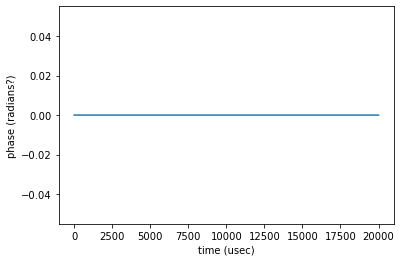

In [3]:
# Plot the raw data
phase_timestream.plot_phasetime(phase_timestream.data_nonoise)

In [4]:
# Define a photon pulse
phase_timestream.gen_photon_pulse(tr=4, tf=30);

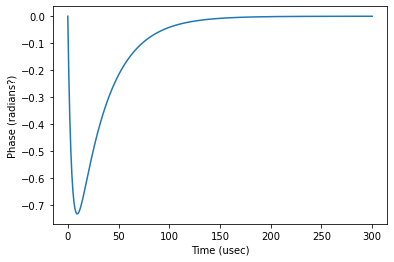

In [5]:
# Plot the pulse
phase_timestream.plot_pulse()

In [6]:
# Generate photon arrival times
phase_timestream.gen_photon_arrivals(cps=500)

array([False, False, False, ..., False, False, False])

In [7]:
# Verify how many photons we got
print(phase_timestream.photon_arrivals.sum())

12


In [8]:
# Populate phase data with photon pulses
phase_timestream.populate_photons()

array([0., 0., 0., ..., 0., 0., 0.])

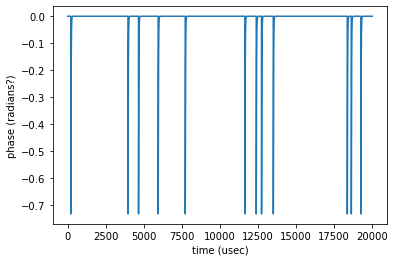

In [9]:
# Plot new phase data
phase_timestream.plot_phasetime(phase_timestream.data_nonoise)

In [10]:
readout = MKIDReadout()

# Trigger on photons
readout.trigger(phase_timestream, phase_timestream.data_nonoise)

array([False, False, False, ..., False, False, False])

In [11]:
# Count Triggers
print('Photons:', phase_timestream.photon_arrivals.sum(), 'Triggers:', readout.trig.sum())

Photons: 12 Triggers: 12


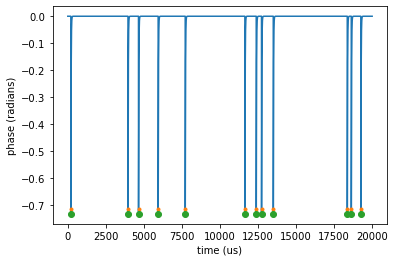

In [12]:
# Record energies of triggered values
readout.record_energies(phase_timestream.data_nonoise)

# Plot trigger events and recorded energies
readout.plot_triggers(phase_timestream, phase_timestream.data_nonoise, energies=True)

In [13]:
# Record triggered values
readout.record_energies(phase_timestream.data_nonoise)

array([-0.73317576, -0.73317576, -0.73317576, -0.73317576, -0.73317576,
       -0.73317576, -0.73317576, -0.73317576, -0.73317576, -0.73317576,
       -0.73317576, -0.73317576])

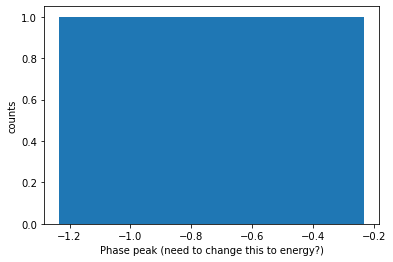

In [14]:
# Plot histogram of "energies"
readout.plot_energies()

# Add Noise

In [15]:
phase_timestream.set_tls_noise(scale=1e-3)

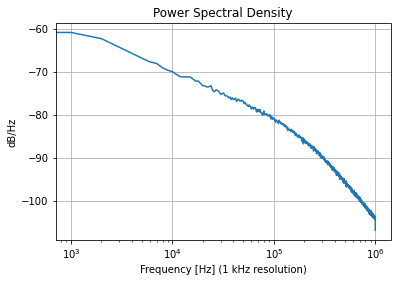

In [16]:
mkidnoiseanalysis.plot_psd(phase_timestream.tls_noise)

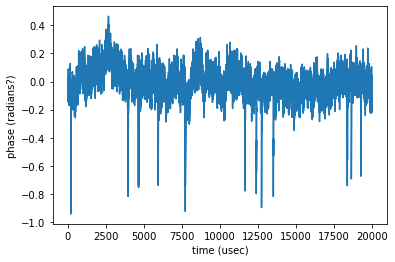

In [17]:
# Plot new phase data
phase_timestream.plot_phasetime(phase_timestream.data)

In [18]:
# Trigger on photons
readout.trigger(phase_timestream, phase_timestream.data, threshold=-0.6, deadtime=30)

array([False, False, False, ..., False, False, False])

In [19]:
# Count Triggers
print('Photons:', phase_timestream.photon_arrivals.sum(), 'Triggers:', readout.trig.sum())

Photons: 12 Triggers: 12


In [20]:
# Record energies of triggered values
readout.record_energies(phase_timestream.data)

array([-0.94179047, -0.81704627, -0.75421544, -0.73902208, -0.9235462 ,
       -0.77877807, -0.79815835, -0.89665044, -0.81823609, -0.74178755,
       -0.69249708, -0.67306788])

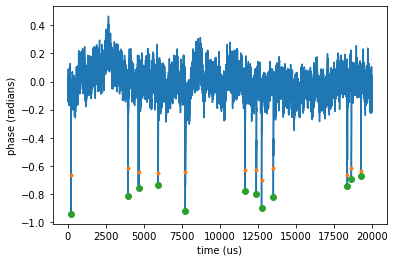

In [21]:
# Plot trigger events with energies
readout.plot_triggers(phase_timestream, phase_timestream.data, energies=True)

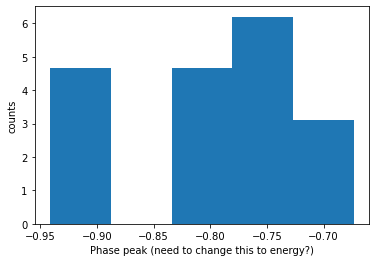

In [22]:
# Plot energy histogram
readout.plot_energies()

# Resonator

In [23]:
# Define resonator parameters
res_params = {'f0': 4.0012e9,  # resonance frequency [Hz]
              'qi': 200000,  # internal quality factor
              'qc': 15000,  # coupling quality factor
              'xa': 0.5,  # resonance fractional asymmetry
              'a': 0,  # inductive nonlinearity
              'alpha': 1.,  # IQ mixer amplitude imbalance
              'beta': 0.,  # IQ mixer phase imbalance
              'gain0': 3.0,  # gain polynomial coefficients
              'gain1': 0,  # linear gain coefficient
              'gain2': 0,  # quadratic gain coefficient
              'phase0': 0,  # total loop rotation in radians
              'tau': 50e-9}  # cable delay

In [24]:
# Define frequency sweep
fsweep_params = {'fc': 4.0012e9,  # center frequency [Hz]
                 'points': 1000,  # frequency sweep points
                 'span': 500e6,  # frequency sweep bandwidth [Hz]
                 'increasing': True}  # frequency sweep direction

In [25]:
# Create resonator and compute S21
res = Resonator(**res_params)
res.fsweep(**fsweep_params)
s21 = res.s21

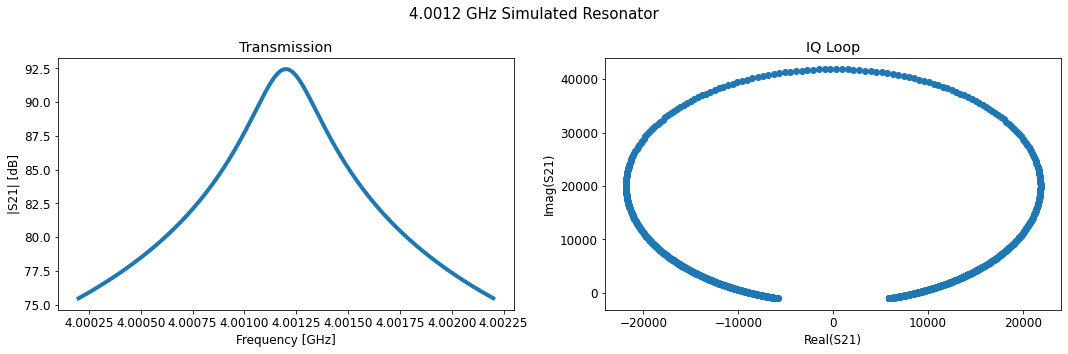

In [27]:
# Plot S21
res.plot_trans()

# Photon Event


In [29]:
response = ResonatorResponse(res, phase_timestream)

KeyError: 'f0'